This notebook is used to create a graph between courses based on common themes identified using topic detection.


In [1]:
# Useful starting lines
%matplotlib inline
import os
import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA, TruncatedSVD, SparsePCA
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from scipy import sparse, stats, spatial
import pickle

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package wordnet to /Users/laila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/laila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laila/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load the courses descriptions dataframe
courses = pd.read_pickle("../data/cleaned_courses_STI.pickle")
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,KeyWords_FR,KeyWords_EN,StudyPlans,Requirements,Summary_Concepts_Contents_EN,Summary_Concepts_Contents_FR
CourseCode,,,,,,,,,,,
BIOENG-404,2016-2017,Analysis and modelling of locomotion,NaN,220184;115955;104385,266358;223203;170511;255602;181161;267756;210551,"[neurophysiology, motor system, l ocomotion, k...","[neurophysiology, motor system, locomotion, ki...",EDNE -; SV,[],"[neuroprosthetics, and link to biped robot, ga...","[la biomécanique, la modélisation numérique, l..."
BIOENG-430,2016-2017,Introduction to cellular and molecular biotech...,NaN,162095,NaN,"[biotechnologie, expression génique, transgénè...","[biotechnology, gene expression, trasngenesis,...",CGC; Mineur : Biotechnologie -,[],"[, the course present comparatively several to...",[soulignant la réduction de l'impact environne...
BIOENG-433,2016-2017,Biotechnology lab (for CGC),NaN,110882,252599;253981;273636;273637;243036;273638;2427...,[],[],CGC; Mineur : Biotechnologie -,[BIOENG-437],[they purify the recombinant protein and chara...,[ce cours donnera l'opportunité de se familiar...
BIOENG-437,2016-2017,Pharmaceutical biotechnology,NaN,110882,NaN,[],[],CGC; Mineur : Biotechnologie -,[],[the course will try to trace back the think a...,[the course will try to trace back the think a...
BIOENG-442,2016-2017,Biomaterials,NaN,106911;254787,243036;260304;253981;266152,[],"[cell, extracellular matrix, tissue, regenerat...",CGC; Mineur : Neuroprosthétiques -; Mineur : T...,[],[this course cover the fundamental concept beh...,[ce cours couvre le concept fondamentaux sur l...


# 1. Formatting Keywords for LDA

Helper functions to format the keywords

In [3]:
def keywords_to_list(columns, dataframe):
    # Create a keywords dataframe per column and store in a list
    keywords_df = list()
    # Enumerate along the columns: "keywords_EN, keywords_FR ..."
    for c, categ in enumerate(columns):
        # Make a copy
        df = dataframe[[categ]].copy()
        # Join the elements in the lists with the ;
        df[categ] = df[categ].apply(lambda x: ";".join(x))
        # Split the dataframe on the ;
        df = df[categ].str.split(";", expand = True)
    
        keywords = list()
        
        # Format all the strings 
        for col in df.columns:
            df[col] = df[col].str.replace(r'^ +', "")
            df[col] = df[col].str.replace(r' +$', "")
            df[col] = df[col].str.replace(r'/|\\', " ")   
            df[col] = df[col].str.replace(r'\r', "")
            df[col] = df[col].str.replace(r'\(|\)|:', "")
            
            # Add the new keywords
            keywords += list(df[col].unique())
            
        # Append the cleaned dataframe
        keywords_df.append(df)
        # Get the full list of keywords
        keywords = sorted(filter(None,list(set(keywords))))
    return keywords, keywords_df


def split_words(x):
    if type(x) is str:
        x = x.lower()
        for symbol in [";",",",".","\n"," - ", "- ","_", " "]:
            if type(x) is not str:
                temp = list()
                for word in x:
                    temp += word.split(symbol)
                x = temp
            else:
                x = x.split(symbol)
        
        return list(filter(None, x))
    else:
        return []

In [4]:
keywords_df = list()
list_col = ["KeyWords_EN", "Summary_Concepts_Contents_EN"]
language = "english"
keywords, keywords_df = keywords_to_list(list_col, courses)

print("There are {} distinct keywords in english".format(len(keywords)))


There are 955 distinct keywords in english


In [5]:
# Concatenate the results of the different columns to obtain one line per course
result = pd.concat(keywords_df, axis=1, join_axes=[keywords_df[0].index])#pd.concat(keywords_df,axis=1, join='outer')

lda_data = list()

for row in result.values:
    try:
        interm_data = " ".join(list(set(filter(None, row))))
    except:
        interm_data = list(set(filter(None, row)))
    lda_data.append(interm_data)

print("We have strings for {} courses".format(len(lda_data)))
 
result.head()

We have strings for 196 courses


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
CourseCode,,,,,,,,,,,,,,,,,,,,,
BIOENG-404,neurophysiology,motor system,locomotion,kinematics,gait analysis,matlab,numerical model,robotics,neuroprosthetics,None,...,None,None,None,None,None,None,None,None,None,None
BIOENG-430,biotechnology,gene expression,trasngenesis,biocatalysis,green chemistry,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
BIOENG-433,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
BIOENG-437,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
BIOENG-442,cell,extracellular matrix,tissue,regeneration,angiogenesis,biodegradable material,hydrogel,drug delivery,micro,and nano-particles,...,None,None,None,None,None,None,None,None,None,None


In [6]:
distinct_words = lda_data.copy()

distinct_words = [split_words(x) for x in lda_data]
distinct_words_per_course = [len(list(set(list(filter(None, x))))) for x in distinct_words]
distinct_words = sum(distinct_words, [])
distinct_words = list(set(list(filter(None, distinct_words))))
med_num_distinct_words = np.median(np.array(distinct_words_per_course))
print("We have {} distinct words which make up the strings".format(len(distinct_words)))
print("Median number of distinct words per course : {}".format(med_num_distinct_words))

We have 1919 distinct words which make up the strings
Median number of distinct words per course : 34.0


# 2. Isolating Topics Using LDA

Functions used to perform the LDA

In [7]:
def print_top_words(model, feature_names, n_top_words):
    topics_keywords = list()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        topics_keywords.append([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()
    return topics_keywords


def perform_LDA(data_samples, language, n_samples, n_features, n_components, n_top_words):

    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    stop_words = stopwords.words(language)
    tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                    max_features=n_features,
                                    stop_words=stop_words)
    
    tfidf = tf_vectorizer.fit_transform(data_samples)
    pca = PCA()
    pca_tfidf = pca.fit_transform(tfidf.toarray())

    print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..." % (n_samples, n_features))
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=25,
                                    learning_method='batch',
                                    learning_offset=50.,
                                    random_state=0)
    
    result = lda.fit_transform(pca_tfidf-np.min(pca_tfidf))

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    topics_keywords = print_top_words(lda, tf_feature_names, n_top_words)
    
    return result, lda

Performing LDA on the previously formatted keywords

In [8]:
n_samples = len(lda_data)
n_features = len(distinct_words)
n_components = 10
n_top_words = 20

print(n_samples, n_features)

result_lda,lda = perform_LDA(lda_data, language,n_samples, n_features, n_components, n_top_words)


196 1919
Extracting tf features for LDA...
Fitting LDA models with tf features, n_samples=196 and n_features=1919...

Topics in LDA model:
Topic #0: direct diode dimensional digital different differential difference diagnostic device development determine develop detection detail described design description depth describe depend
Topic #1: direct diode dimensional digital different differential difference diagnostic device development determine develop detection detail described design description depth describe depend
Topic #2: direct diode dimensional digital different differential difference diagnostic device development determine develop detection detail described design description depth describe depend
Topic #3: 6ghz aberration ability able abstract acoustic acquaint acquire acquires acquisition active act activity actuator add addition address adaptive advance afm
Topic #4: direct diode dimensional digital different differential difference diagnostic device development determine

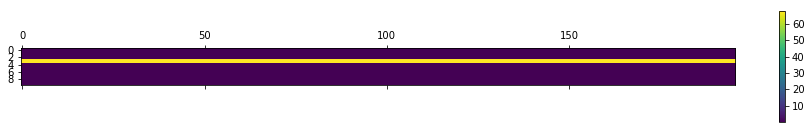

In [9]:

plt.matshow(lda.components_)
plt.colorbar()

In [10]:
result_lda

array([[ 0.00146404,  0.00146404,  0.00146404, ...,  0.00146404,
         0.00146404,  0.00146404],
       [ 0.00145657,  0.00145657,  0.00145657, ...,  0.00145657,
         0.00145657,  0.00145657],
       [ 0.0014606 ,  0.0014606 ,  0.0014606 , ...,  0.0014606 ,
         0.0014606 ,  0.0014606 ],
       ..., 
       [ 0.00142359,  0.00142359,  0.00142359, ...,  0.00142359,
         0.00142359,  0.00142359],
       [ 0.00146378,  0.00146378,  0.00146378, ...,  0.00146378,
         0.00146378,  0.00146378],
       [ 0.00143327,  0.00143327,  0.00143327, ...,  0.00143327,
         0.00143327,  0.00143327]])

# 3. Computing the Distance Between Courses Based on the LDA Results

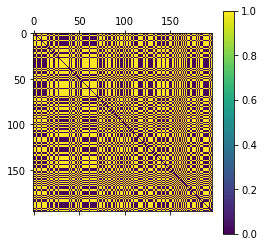

In [11]:
feature_vectors = result_lda.copy()
feature_vectors -= feature_vectors.mean(axis=0)
feature_vectors /= feature_vectors.std(axis=0)
distances = spatial.distance.pdist(feature_vectors, metric = "cosine")
distances = spatial.distance.squareform(distances) 
kernel_width = (distances.mean())
weights = np.exp(-np.power(distances, 2)/(kernel_width**2))
weights[np.diag_indices_from(weights)] = 0


plt.matshow(weights);
plt.colorbar();

** Saving the weight matrix **

In [12]:
pkl_file = open(os.path.join(os.getcwd(), "Graphs","topics_graph.pkl"), "wb")
pickle.dump(weights, pkl_file)
pkl_file.close()